# Data exploration for NYTimes news data

By: Mali Akmanalp, Kevin Shain, Jose Ramon Morales Arilla

In [44]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

First, we load up the data, which is in separate yearly files after scraping:

In [2]:
DATA_DIR = "./data/"

In [3]:
all_data_list = []
for year in range(1990,2017):
    data = pd.read_csv(DATA_DIR + '{}_Output.csv'.format(year), header=None, encoding="utf-8")
    all_data_list.append(data) # list of dataframes
data = pd.concat(all_data_list, axis=0)
data.columns = ['id','date','headline', 'lead']

# Drop dupes and fix dates
data = data.drop_duplicates("id").reset_index(drop=True)
data.date = pd.to_datetime(data.date)

# Fill null articles
data.loc[data.lead.isnull(), "lead"] = ""

In [4]:
data.head()

,id,date,headline,lead
0,4fd1aa888eb7c8105d6c860e,1990-01-03,Tandem Expected To Show Computer,LEAD: Tandem Computers Inc. is expected to int...
1,52b85b7738f0d8094087c782,1990-01-03,Chrysler Shows Van Concept,LEAD: The Chrysler Corporation today introduce...
2,52b85b7638f0d8094087c780,1990-01-02,Loan Pact Seen For Hungary,LEAD: Hungary expects to complete a deal with ...
3,52b85b7538f0d8094087c77f,1990-01-02,Counterattack Planned By Lawyers for Lincoln,"LEAD: Lawyers for Charles H. Keating Jr., who ..."
4,4fd18d4c8eb7c8105d691815,1990-01-08,Intermetrics Inc reports earnings for Qtr to N...,LEAD: *3*** COMPANY REPORTS ** *3* Intermetric...


Let's first just take a look at the article count across time:

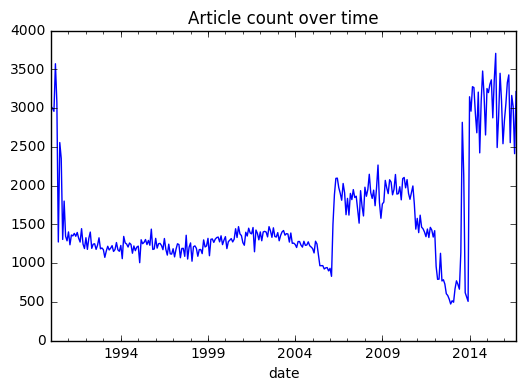

In [60]:
data.groupby("date").id.count().resample("MS").sum().plot(title="Article count over time")

This is odd - there are some strange breaks on number of articles throughout the years. It makes sense that it increases over time because of increased digitization procedures and such, but the earlier spike in 1990 is very odd, and ignoring 1990 might be a good idea. This also highlights the importance on using measures that are normalized by the amount of text - more articles shouldn't mean more positive sentiment.

We can now drill deeper into the words:

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
c = CountVectorizer(min_df=75, stop_words="english")
m = c.fit_transform(data.headline)

In [8]:
m = pd.DataFrame(m.toarray(), columns=c.get_feature_names(), dtype=pd.np.bool)

In [9]:
m.shape

(502565, 4698)

Here are some simple statistics on words:

In [10]:
word_counts = m.sum(axis=0)

In [15]:
word_counts.nlargest(20)

business    24031
new         20260
earnings    16404
says        15911
reports     14933
deal        14260
bank        13014
briefing    13009
world       11514
million     11357
profit      10835
qtr         10607
billion     10326
china       10241
buy          9314
market       9259
sales        8935
chief        8828
company      8532
europe       8358
dtype: int64

In [16]:
word_counts.nsmallest(20)

110            75
bitter         75
bob            75
bulgaria       75
conrad         75
declares       75
defence        75
depends        75
discussed      75
domino         75
enforcement    75
engineers      75
exempt         75
expecting      75
exporters      75
flag           75
flexible       75
grant          75
households     75
hynix          75
dtype: int64

Looking at the appearance distribution of words, it has an extremely long tail as expected:

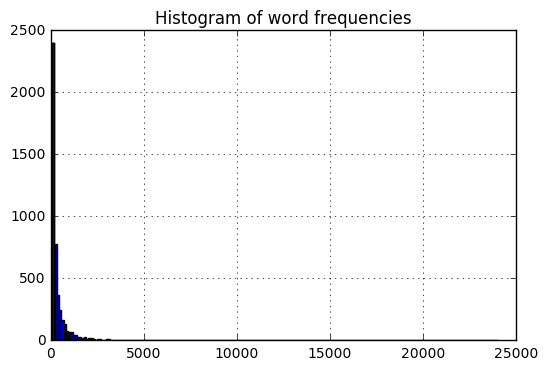

In [59]:
word_counts.hist(bins=200)
plt.title("Histogram of word frequencies")

The same graph with a log scale:

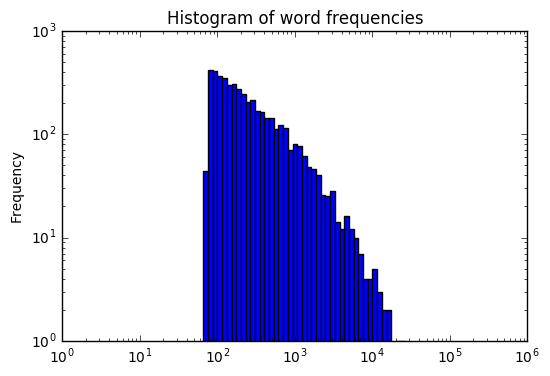

In [58]:
word_counts.plot(bins=pd.np.logspace(0, pd.np.log10(1000000), 100), kind='hist', loglog=True, xlim=(0,1000000))
plt.title("Histogram of word frequencies")

The vectorized word matrix is fairly large, even after filtering out the least common words. PCA / T-SNE took an extremely long time to run, ate up all available memory, and would not complete in a reasonable time. We performed some experimentation with sparse matrices and Incremental PCA, but couldn't get something to complete in a reasonable time, so we left that alone.

Finally, we ran some experiments to confirm in the data our intuitions about the real world:

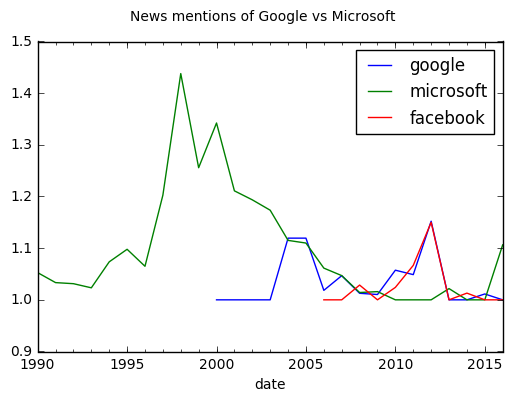

In [53]:
data[m.google == 1].groupby("date").id.count().resample("AS").mean().plot(label="google")
data[m.microsoft == 1].groupby("date").id.count().resample("AS").mean().plot(label="microsoft")
data[m.facebook == 1].groupby("date").id.count().resample("AS").mean().plot(label="facebook")
plt.legend()
plt.suptitle("News mentions of Google vs Microsoft")

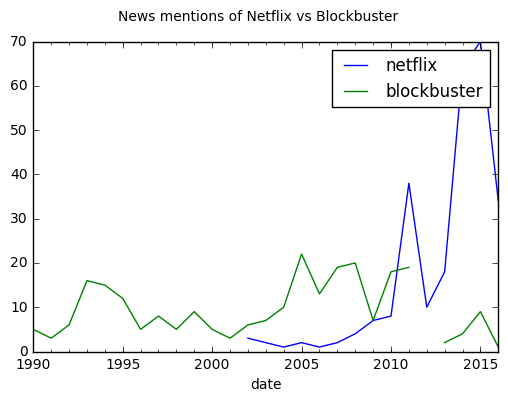

In [57]:
data[m.netflix == 1].groupby("date").id.count().resample("AS").sum().plot(label="netflix")
data[m.blockbuster == 1].groupby("date").id.count().resample("AS").sum().plot(label="blockbuster")
plt.legend()
plt.suptitle("News mentions of Netflix vs Blockbuster")